In [39]:
#https://www.alphavantage.co/academy/#ai-for-finance

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from alpha_vantage.timeseries import TimeSeries 

import requests
import pandas as pd
from pandas.io.json import json_normalize

print("All libraries loaded")

All libraries loaded


In [40]:
#Get Basic Stock Data

# Replace "demo" with your own API key from https://www.alphavantage.co/support/#api-key
apikey = "NA4DC7S59VGKCP4Y"
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=IBM&apikey={apikey}&outputsize=full'

# Send a GET request to the API
r = requests.get(url)
data = r.json()

# Extract the time series data
time_series = data['Time Series (Daily)']

# Create a DataFrame from the time series data
df = pd.DataFrame(time_series).T

# Rename the columns
df.columns = ['Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume', 'Dividend Amount', 'Split Coefficient']

# Convert the column data types
df = df.astype({
    'Open': float,
    'High': float,
    'Low': float,
    'Close': float,
    'Adjusted Close': float,
    'Volume': int,
    'Dividend Amount': float,
    'Split Coefficient': float
})

# Sort the DataFrame by date
df.sort_index(ascending=True, inplace=True)

# Reset the index
df.reset_index(inplace=True)

df.rename(columns={'index': 'Date'}, inplace=True)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Specify the desired start and end dates
start_date = '2010-06-01'
end_date = '2023-06-30'

# Filter the DataFrame based on the start and end dates
filtered_basic = df.loc[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Reset the index without keeping the original index values
filtered_basic.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
print(filtered_basic.head)



<bound method NDFrame.head of            Date    Open    High      Low   Close  Adjusted Close   Volume  \
0    2010-06-01  124.69  126.88  124.200  124.34       75.027740  7135400   
1    2010-06-02  124.85  127.50  124.350  127.41       76.880202  7705300   
2    2010-06-03  127.75  128.22  126.460  127.96       77.212077  6645300   
3    2010-06-04  126.37  127.10  124.670  125.28       75.594944  9669200   
4    2010-06-07  125.57  125.86  124.130  124.13       74.901024  6951400   
...         ...     ...     ...      ...     ...             ...      ...   
3289 2023-06-26  129.39  131.41  129.310  131.34      131.340000  4845649   
3290 2023-06-27  131.30  132.95  130.830  132.34      132.340000  3219909   
3291 2023-06-28  132.06  132.17  130.910  131.76      131.760000  2753779   
3292 2023-06-29  131.75  134.35  131.690  134.06      134.060000  3639836   
3293 2023-06-30  134.69  135.03  133.425  133.81      133.810000  4236677   

      Dividend Amount  Split Coefficient  
0 

In [41]:
config = {
    "alpha_vantage": {
        "key": 'NA4DC7S59VGKCP4Y', # you can use the demo API key for this project, but please make sure to get your own API key at https://www.alphavantage.co/support/#api-key
        "symbol": "IBM",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    },

    "alpha_vantage": {
        "symbol": "AAPL",  # Replace with your desired symbol
        "outputsize": "full",  # Replace with your desired output size
        "key_adjusted_close": "5. adjusted close"  # Replace with the appropriate key for adjusted close price
    },
    "plots": {
        "color_actual": "blue",  # Replace with your desired color
        "xticks_interval": 10  # Replace with your desired interval for x-ticks
    }

    
}

In [42]:
#Get inflation data

# Replace the "demo" API key below with your own key from https://www.alphavantage.co/support/#api-key
url = 'https://www.alphavantage.co/query?function=INFLATION&apikey=NA4DC7S59VGKCP4Y'
r = requests.get(url)
data = r.json()

# Convert the data to a pandas DataFrame
df = pd.DataFrame.from_dict(data)

# Normalize the "data" column
inflation = json_normalize(df['data'])

# Add the normalized data as columns to the DataFrame
df['date'] = inflation['date']
df['value'] = inflation['value']

# Rename the 'DATE' column to 'Date'
inflation.rename(columns={'date': 'Date'}, inplace=True)

# Filter the data based on the desired date range
start_date = '2010-06-01'
end_date = '2023-06-30'
filtered_inflation = inflation[(inflation['Date'] >= start_date) & (inflation['Date'] <= end_date)]



/var/folders/qy/3nm4yxds0yqgsybrtw7vhftm0000gn/T/ipykernel_7981/2785394002.py:12: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead.
  inflation = json_normalize(df['data'])


In [43]:
#merge data

# Convert the 'Date' column in filtered_inflation to datetime
filtered_inflation['Date'] = pd.to_datetime(filtered_inflation['Date'])

import pandas as pd

# Merge the inflation dataset using concat
merged_data = pd.concat([filtered_basic.set_index('Date'), filtered_inflation.set_index('Date')['value']], axis=1, join='outer')

# Fill missing values for all columns
merged_data.fillna(method='ffill', inplace=True)
merged_data.fillna(method='bfill', inplace=True)

# Check missing values
missing_values = merged_data.isnull().sum()
print(missing_values)

# Convert "value" column to float
merged_data['value'] = merged_data['value'].astype(float)

# Display the merged DataFrame
print(merged_data)


Open                 0
High                 0
Low                  0
Close                0
Adjusted Close       0
Volume               0
Dividend Amount      0
Split Coefficient    0
value                0
dtype: int64
              Open    High      Low   Close  Adjusted Close     Volume  \
Date                                                                     
2010-06-01  124.69  126.88  124.200  124.34       75.027740  7135400.0   
2010-06-02  124.85  127.50  124.350  127.41       76.880202  7705300.0   
2010-06-03  127.75  128.22  126.460  127.96       77.212077  6645300.0   
2010-06-04  126.37  127.10  124.670  125.28       75.594944  9669200.0   
2010-06-07  125.57  125.86  124.130  124.13       74.901024  6951400.0   
...            ...     ...      ...     ...             ...        ...   
2023-06-26  129.39  131.41  129.310  131.34      131.340000  4845649.0   
2023-06-27  131.30  132.95  130.830  132.34      132.340000  3219909.0   
2023-06-28  132.06  132.17  130.910  131

/var/folders/qy/3nm4yxds0yqgsybrtw7vhftm0000gn/T/ipykernel_7981/832202225.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_inflation['Date'] = pd.to_datetime(filtered_inflation['Date'])


In [44]:
# Normalize data
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        normalized_x = (x - self.mu) / self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x * self.sd) + self.mu


# Normalize
scaler = Normalizer()
normalized_data = scaler.fit_transform(merged_data)

# Create a new DataFrame with the normalized data
normalized_df = pd.DataFrame(normalized_data, columns=merged_data.columns, index=merged_data.index)

normalized_df




,Open,High,Low,Close,Adjusted Close,Volume,Dividend Amount,Split Coefficient,value
Date,,,,,,,,,
2010-06-01,-1.180096,-1.139681,-1.153907,-1.194710,-2.818585,0.905250,-0.121992,-0.017395,0.194613
2010-06-02,-1.173797,-1.115292,-1.148007,-1.073948,-2.677145,1.120819,-0.121992,-0.017395,0.194613
2010-06-03,-1.059627,-1.086969,-1.065009,-1.052313,-2.651805,0.719867,-0.121992,-0.017395,0.194613
2010-06-04,-1.113956,-1.131027,-1.135420,-1.157734,-2.775278,1.863677,-0.121992,-0.017395,0.194613
2010-06-07,-1.145451,-1.179806,-1.156661,-1.202971,-2.828260,0.835651,-0.121992,-0.017395,0.194613
...,...,...,...,...,...,...,...,...,...
2023-06-26,-0.995062,-0.961481,-0.952903,-0.919356,1.481014,0.039137,-0.121992,-0.017395,2.432932
2023-06-27,-0.919867,-0.900901,-0.893113,-0.880020,1.557366,-0.575810,-0.121992,-0.017395,2.432932
2023-06-28,-0.889946,-0.931585,-0.889966,-0.902835,1.513082,-0.752127,-0.121992,-0.017395,2.432932


In [50]:
num_data_points = len(normalized_data)

data_date = normalized_data.index

def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size, x.shape[1]), strides=(x.strides[0], x.strides[0], x.strides[1]))
    return output[:-1], output[-1]

def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data.values, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data.values, window_size=config["data"]["window_size"])

# split dataset
split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
train_x = data_x[:split_index]
test_x = data_x[split_index:]
train_y = data_y[:split_index]
test_y = data_y[split_index:]

#prepare data for plotting

num_data_points



3306

In [52]:
# let's check if total observation makes sense
print(train_x.shape )
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2628, 20, 9)
(658, 20, 9)
(2628, 9)
(658, 9)


ValueError: x and y must have same first dimension, but have shapes (3306,) and (2628, 9)

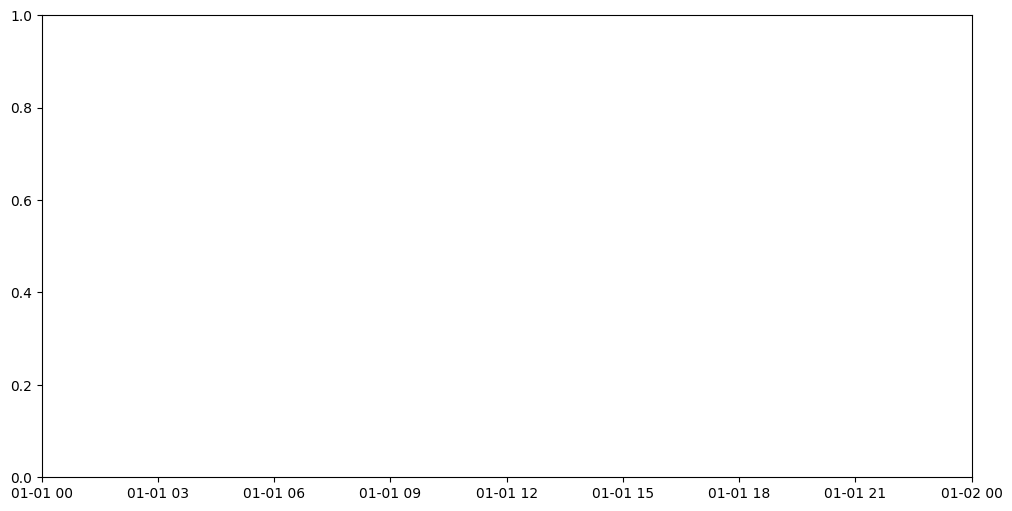

In [55]:
# Prepare data for plotting
to_plot_data_y_train = np.where(train_y == 0, None, train_y)
to_plot_data_y_val = np.where(test_y== 0, None, test_y)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data_date, to_plot_data_y_train, label="Training Data", color="blue")
plt.plot(data_date, to_plot_data_y_val, label="Validation Data", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Training and Validation Data")
plt.legend()
plt.grid(True)
plt.show()